In [177]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import pickle
import gzip
import torchvision.transforms.functional as TF
import random
from sklearn.model_selection import train_test_split

# Data loading

Load datasets:

In [178]:
with gzip.open('/content/flatland_train.data', 'rb') as f:
    X_tr, y_tr = pickle.load(f)
with gzip.open('/content/flatland_test.data', 'rb') as f:
    X_t, y_t = pickle.load(f)

Modify labels for better performance:

In [179]:
for idx in range(len(y_tr)):
    if y_tr[idx] == 3:
        y_tr[idx] = 1
    elif y_tr[idx] == 4:
        y_tr[idx] = 2
    elif y_tr[idx] == 5:
        y_tr[idx] = 3
    elif y_tr[idx] == 6:
        y_tr[idx] = 4

X_tr = torch.tensor(X_tr, dtype=torch.float32).unsqueeze(1)
X_t = torch.tensor(X_t, dtype=torch.float32).unsqueeze(1)
y_tr = torch.tensor(y_tr, dtype=torch.long)

In [180]:
def plot_one_image(tensor_of_images,tensor_of_labels,idx):
  image  = tensor_of_images[idx]
  label = tensor_of_labels[idx]
  image = image.numpy().squeeze()

  plt.imshow(image, cmap='gray')
  plt.title(f'Label: {label}')
  plt.show()

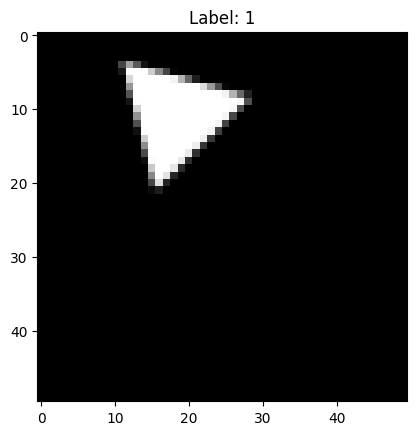

In [181]:
plot_one_image(X_tr,y_tr,5)

# Data augmentation


Vertical,  horizontal and vertical AND horizontal flips on randomly selected 6000 images.


In [182]:
num_random_samples = 6000
random.seed(42)

selected_indices = random.sample(range(len(X_tr)), num_random_samples)
augmented_images = []
augmented_labels = []

for idx in selected_indices:
    image_tensor = X_tr[idx]
    label = y_tr[idx]

    horizontal_flip = TF.hflip(image_tensor)
    vertical_flip = TF.vflip(image_tensor)
    hv_flip = TF.hflip(vertical_flip)

    augmented_images.extend([horizontal_flip, vertical_flip, hv_flip])
    augmented_labels.extend([label, label, label])

augmented_images = torch.stack(augmented_images)
augmented_labels = torch.tensor(augmented_labels, dtype=torch.long)

X_combined = torch.cat((X_tr, augmented_images), dim=0)
y_combined = torch.cat((y_tr, augmented_labels), dim=0)

train_dataset = torch.utils.data.TensorDataset(X_combined, y_combined)

print(f"Augmented dataset size: {len(augmented_images)}")
print(f"Combined dataset size: {len(train_dataset)}")

Augmented dataset size: 18000
Combined dataset size: 28000


Rotations of 90,180 and 270 degrees are applied to randomly selected 6000 images.


In [183]:
num_random_samples = 6000
random.seed(42)

selected_indices = random.sample(range(10000), num_random_samples)
augmented_images = []
augmented_labels = []

for idx in selected_indices:
    image_tensor = X_tr[idx]
    label = y_tr[idx]

    rotation_90 = TF.rotate(image_tensor, 90)
    rotation_180 = TF.rotate(image_tensor, 180)
    rotation_270 = TF.rotate(image_tensor, 270)

    augmented_images.extend([rotation_90, rotation_180, rotation_270])
    augmented_labels.extend([label, label, label])

augmented_images = torch.stack(augmented_images)
augmented_labels = torch.tensor(augmented_labels, dtype=torch.long)

X_c = torch.cat((X_combined, augmented_images), dim=0)
y_c = torch.cat((y_combined, augmented_labels), dim=0)

train_dataset = torch.utils.data.TensorDataset(X_c, y_c)

print(f"Augmented dataset size: {len(augmented_images)}")
print(f"Combined dataset size: {len(X_c)}")

Augmented dataset size: 18000
Combined dataset size: 46000


# Training dataset and model training

Now we can create train dataset and train/test loader for the model.

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X_c, y_c, test_size=0.1, random_state=42)

In [185]:
train_dataset = torch.utils.data.TensorDataset(X_train,y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = torch.utils.data.TensorDataset(X_test,y_test)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = 64,shuffle = False)
test_loader1 = torch.utils.data.DataLoader(X_t,batch_size = 64,shuffle = False)

In [186]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Model's architecture:

In [187]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

In [188]:
model = CNN().to(device)

Here we define loss function, optimizer and learning rate scheduler.

In [189]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters(), rho=0.9, weight_decay=0,lr = 1.0, eps = 1e-6)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Model training:

In [190]:
num_epochs = 25
losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()
    losses.append(running_loss / len(train_loader))
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

Epoch 1, Loss: 0.7790736985699471
Epoch 2, Loss: 0.2409002777632366
Epoch 3, Loss: 0.17456091986753197
Epoch 4, Loss: 0.15382433455895167
Epoch 5, Loss: 0.13513740423096593
Epoch 6, Loss: 0.13269405564943895
Epoch 7, Loss: 0.12462257285252605
Epoch 8, Loss: 0.12013367438398107
Epoch 9, Loss: 0.1182496837416586
Epoch 10, Loss: 0.11405858921838588
Epoch 11, Loss: 0.09006462026375937
Epoch 12, Loss: 0.08683010222321201
Epoch 13, Loss: 0.08504104222296241
Epoch 14, Loss: 0.08338127634883895
Epoch 15, Loss: 0.08197647800785669
Epoch 16, Loss: 0.08080532768031602
Epoch 17, Loss: 0.07966501770722442
Epoch 18, Loss: 0.07964369481202024
Epoch 19, Loss: 0.07770246636896888
Epoch 20, Loss: 0.07669915721486892
Epoch 21, Loss: 0.07348524936197047
Epoch 22, Loss: 0.07311155724805568
Epoch 23, Loss: 0.0742409665863011
Epoch 24, Loss: 0.07305280943660258
Epoch 25, Loss: 0.07242905886748797


# Model evaluation

Let's evaluate the model on train/test data

In [191]:
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

Model evaluation on train dataset:




In [192]:
evaluate_model(model, train_loader)

Accuracy: 98.65%


Model evaluation on test dataset:


In [193]:
evaluate_model(model, test_loader)

Accuracy: 98.54%


Get model's predictions on test data:

In [194]:
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader1:
        batch_data = batch.to(device)
        pred = model(batch_data)
        predictions.append(pred)

predictions = torch.cat(predictions, dim=0)

In [195]:
u = predictions.argmax(axis=1)

In [196]:
for i in range(len(u)):
  if u[i] == 0:
    continue
  else:
    u[i] += 2

In [197]:
u[0:6]

tensor([6, 6, 4, 5, 5, 3], device='cuda:0')

Print the predicted values:

In [198]:
number_string = ''.join(str(int(num)) for num in u)
print(number_string)

6645533343400063340545465645540463050355560333004353364366664004553303655503043350530604500355355463530403305345345040035350650004555530445455543654345046545635535636546303536656365650360305556463535335353336335465353306053566453360450054500063446060346543400453533456446546354503345300344553655053533306444055353443403030605300054655506334560544330054354500443044350645463346060306564305553645045355533336636330650644345564354535003644433663304055544504505345553050664300303444544504030306344006554333400506536544330334035643434343650403330363543435603556453440550543403430450565505303434536654355435035004453066464566036403330463455364406563043554443345350563053555660564533336350334356344353343060333043443433504546433334035630054450544503643600503355633656300553303033036463444450546453433660605604345456536403330035505464066564430553033365340544530633543635653364030035430440356534344063550033036433354560635035440504640065344340360630645656404363635646435404000566355305364003035300453665355504